In [1]:
#Imports
import numpy as np
from astropy.table import Table
from astropy import constants as const
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, interp1d 
import os
import time
from tqdm import tqdm
%matplotlib inline

In [39]:
#Checking if the changes have been added
dataset_dir = "C:\\Users\\nachi\\OneDrive\\Desktop\\Hawkins Lab\\datasets"

tmplt_data_path = os.path.join(dataset_dir,"UPDATED_TEMPELATE_SPECTRA.fits")
spec_data_path = os.path.join(dataset_dir,"HETVIPS_LAMOST_SPEC_UPDATED.fits")

spec_data = Table.read(spec_data_path)
tmplt_data = Table.read(tmplt_data_path)

In [40]:
observed_specs = np.array(spec_data["spec_norm"])
observed_wavelengths = np.linspace(3570,5440,len(observed_specs[0]))

norm_tmplt_specs = np.array(tmplt_data["norm_specs"])

In [41]:
def chi_sq(observed_spectra,norm_tmplt_specs,err):
    min_score = np.inf
    min_idx = None
    scores = []
    for i,norm_tmplt in enumerate(norm_tmplt_specs):
        numerator = (observed_spectra-norm_tmplt)**2
        denominator = np.sqrt(err)
        chi_sq_score = np.sum(numerator/denominator)
        scores.append(chi_sq_score)
        if chi_sq_score < min_score:
            min_score = chi_sq_score
            min_idx = i
    
    return min_idx

min_score_idx = []
counter = 0

for observed_spec in tqdm(observed_specs):
    err = np.array(spec_data["updated_var"][counter])
    idx = chi_sq(observed_spec,norm_tmplt_specs,err)
    min_score_idx.append(idx)
    counter += 1

min_score_idx = np.array(min_score_idx)
len(set(min_score_idx))

#plot of chi sq dist
#plot the spectra (w/error) and max/min chi2 template


100%|██████████| 1403/1403 [00:31<00:00, 44.72it/s]


184

In [42]:
errs = np.array(spec_data["updated_var"])
counter = 0
for obj in errs:
    if True in np.isnan(obj):
        counter += 1
counter

0

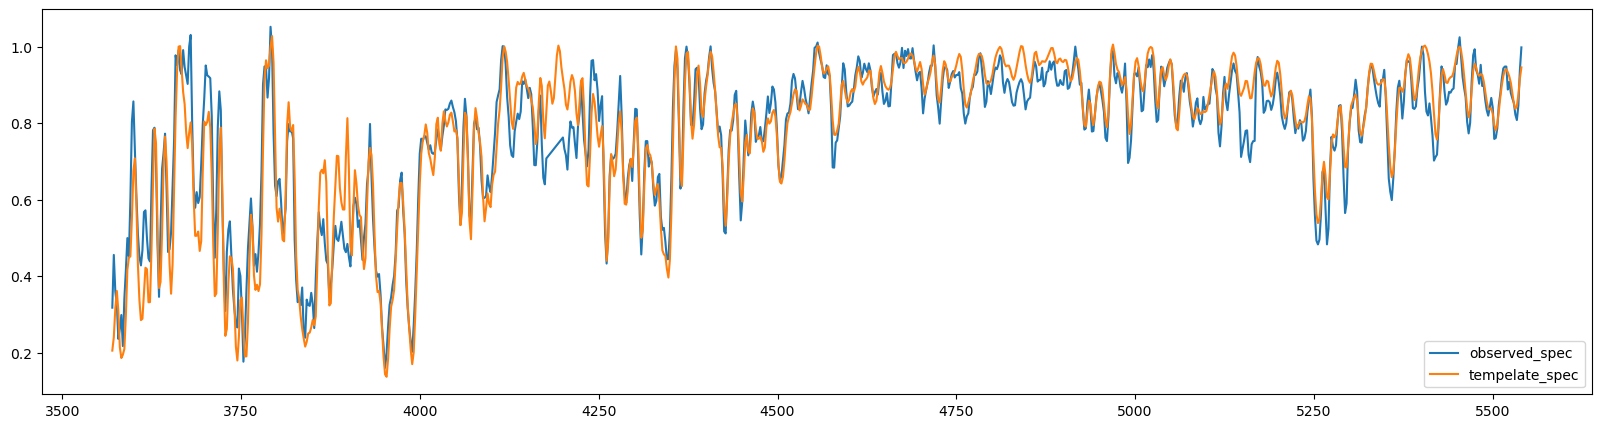

In [43]:
obs_wav = np.linspace(3570,5540,936)
plt.figure(figsize=(20,5))
ex_idx = 0

plt.plot(obs_wav,observed_specs[ex_idx],label="observed_spec")
plt.plot(obs_wav,norm_tmplt_specs[min_score_idx[ex_idx]],label="tempelate_spec")
plt.legend()

In [60]:
"""
#Faster CCF using dot products

c = 299792.46 #c in km/s
iters = 10

def get_score(v,tmplt_spec,observed_spec,observed_wavelengths):
    
    tmplt_shift_const = (v+c)/c #formula (2)
    new_wavelengths = observed_wavelengths * tmplt_shift_const

    #g = interp1d(new_wavelengths,tmplt_spec,fill_value="extrapolate",kind="linear",bounds_error=False)
    test_cs = CubicSpline(new_wavelengths,tmplt_spec)

    interpolated_tmplt_spec = np.array(test_cs(observed_wavelengths))
    return np.dot(interpolated_tmplt_spec,observed_spec)

def ccf(observed_spec,observed_wavelengths,tmplt_spec,high_range):
    start = time.perf_counter()
    negative = False
    negative_rv_score = get_score(-0.5,tmplt_spec,observed_spec,observed_wavelengths)
    positive_rv_score = get_score(0.5,tmplt_spec,observed_spec,observed_wavelengths)

    if negative_rv_score > positive_rv_score:
        high = -high_range
        negative = True

    elif positive_rv_score > negative_rv_score:
        high = high_range

    low = 0
    mid = (low + high)/2

    counter = 0
    predicted_rv = None

    while counter <= iters:

        if not negative:
            mid_plus_score = get_score(mid+1,tmplt_spec,observed_spec,observed_wavelengths)
            mid_minus_score = get_score(mid-1,tmplt_spec,observed_spec,observed_wavelengths)
        else:
            mid_plus_score = get_score(mid-1,tmplt_spec,observed_spec,observed_wavelengths)
            mid_minus_score = get_score(mid+1,tmplt_spec,observed_spec,observed_wavelengths)

        score_delta = mid_plus_score - mid_minus_score

        if score_delta < 0:
            high = mid
            mid = (low + high)/2

        elif score_delta > 0:
            low = mid
            mid = (low + high)/2
        
        predicted_rv = mid
        counter += 1
        
    finish = time.perf_counter()
    
    return predicted_rv


predicted_rvs = []
timings = []
counter = 0
for observed_spec in tqdm(observed_specs[:100]):
    best_tmplt_idx = min_score_idx[counter]
    predicted_rvs.append(   ccf(observed_spec,observed_wavelengths,tmplt_specs[best_tmplt_idx],600.5)   )
    counter += 1
"""

'\n#Faster CCF using dot products\n\nc = 299792.46 #c in km/s\niters = 10\n\ndef get_score(v,tmplt_spec,observed_spec,observed_wavelengths):\n    \n    tmplt_shift_const = (v+c)/c #formula (2)\n    new_wavelengths = observed_wavelengths * tmplt_shift_const\n\n    #g = interp1d(new_wavelengths,tmplt_spec,fill_value="extrapolate",kind="linear",bounds_error=False)\n    test_cs = CubicSpline(new_wavelengths,tmplt_spec)\n\n    interpolated_tmplt_spec = np.array(test_cs(observed_wavelengths))\n    return np.dot(interpolated_tmplt_spec,observed_spec)\n\ndef ccf(observed_spec,observed_wavelengths,tmplt_spec,high_range):\n    start = time.perf_counter()\n    negative = False\n    negative_rv_score = get_score(-0.5,tmplt_spec,observed_spec,observed_wavelengths)\n    positive_rv_score = get_score(0.5,tmplt_spec,observed_spec,observed_wavelengths)\n\n    if negative_rv_score > positive_rv_score:\n        high = -high_range\n        negative = True\n\n    elif positive_rv_score > negative_rv_score:

In [ ]:
"""
#Slower CCF using dot products
c = 299792.46
predicted_rvs = []
def get_score(v,tmplt_spec,observed_spec,observed_wavelengths):
    
    tmplt_shift_const = (v+c)/c #formula (2)
    new_wavelengths = observed_wavelengths * tmplt_shift_const

    test_cs = CubicSpline(new_wavelengths,tmplt_spec)
    interpolated_tmplt_spec = np.array(test_cs(observed_wavelengths))
    return np.dot(interpolated_tmplt_spec,observed_spec)

def ccf(observed_spec,observed_wavelengths,tmplt_spec):
    start = time.perf_counter()
    value_range = np.arange(-1000,1000,0.5)

    scores = []
    for rv in value_range:
        current_score = get_score(rv,tmplt_spec,observed_spec,observed_wavelengths)
        scores.append(current_score)
    predicted_rv = value_range[np.argmax(scores)]
    return predicted_rv

counter = 0
for observed_spec in tqdm(observed_specs[:100]):
    best_tmplt_idx = min_score_idx[counter]
    predicted_rvs.append(   ccf(observed_spec,observed_wavelengths,norm_tmplt_specs[best_tmplt_idx])  )
    counter += 1
"""

In [44]:
#Slower CCF using dot products
c = 299792.46
def get_score(v,tmplt_spec,observed_spec,observed_wavelengths):
    
    tmplt_shift_const = (v+c)/c #formula (2)
    new_wavelengths = observed_wavelengths * tmplt_shift_const
    test_cs = CubicSpline(new_wavelengths,tmplt_spec)
    interpolated_tmplt_spec = np.array(test_cs(observed_wavelengths))
    return np.dot(interpolated_tmplt_spec,observed_spec)

def ccf(observed_spec,observed_wavelengths,tmplt_spec):

    value_range = np.arange(-600,600,1)

    scores = []
    for rv in value_range:
        current_score = get_score(rv,tmplt_spec,observed_spec,observed_wavelengths)
        scores.append(current_score)
    predicted_rv = value_range[np.argmax(scores)]

    return predicted_rv,scores

counter = 0
predicted_rvs = []
scores = []
observed_wavelengths = np.linspace(3570,5440,len(observed_specs[0]))

for observed_spec in tqdm(observed_specs[:100]):
    best_tmplt_idx = min_score_idx[counter]
    predicted_rv, score_arr =  ccf(observed_spec,observed_wavelengths,norm_tmplt_specs[best_tmplt_idx])
    predicted_rvs.append(predicted_rv)
    scores.append(score_arr)
    counter += 1

100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


In [45]:
predicted_rvs

[-83,
 -221,
 -57,
 -88,
 72,
 -124,
 -118,
 -527,
 -11,
 60,
 -588,
 33,
 -141,
 -24,
 -32,
 -158,
 -46,
 9,
 53,
 -5,
 64,
 97,
 -79,
 19,
 -20,
 -43,
 -20,
 37,
 -36,
 -47,
 -163,
 -5,
 -44,
 33,
 15,
 -56,
 -23,
 -75,
 -97,
 -14,
 -51,
 -30,
 -72,
 -71,
 23,
 96,
 10,
 -136,
 3,
 -72,
 -29,
 14,
 -251,
 -51,
 -66,
 18,
 -38,
 -81,
 -57,
 46,
 -80,
 -63,
 -84,
 -29,
 68,
 5,
 72,
 21,
 -158,
 -261,
 158,
 -234,
 158,
 -171,
 -1,
 -102,
 -169,
 -76,
 -94,
 -159,
 -70,
 -30,
 -40,
 -86,
 2,
 1,
 -50,
 134,
 -159,
 -148,
 288,
 -76,
 -296,
 -281,
 -64,
 -272,
 -82,
 -176,
 -80,
 -94]

In [46]:
unique, counts = np.unique(predicted_rvs, return_counts=True)
d = dict(zip(unique, counts))
d

{-588: 1,
 -527: 1,
 -296: 1,
 -281: 1,
 -272: 1,
 -261: 1,
 -251: 1,
 -234: 1,
 -221: 1,
 -176: 1,
 -171: 1,
 -169: 1,
 -163: 1,
 -159: 2,
 -158: 2,
 -148: 1,
 -141: 1,
 -136: 1,
 -124: 1,
 -118: 1,
 -102: 1,
 -97: 1,
 -94: 2,
 -88: 1,
 -86: 1,
 -84: 1,
 -83: 1,
 -82: 1,
 -81: 1,
 -80: 2,
 -79: 1,
 -76: 2,
 -75: 1,
 -72: 2,
 -71: 1,
 -70: 1,
 -66: 1,
 -64: 1,
 -63: 1,
 -57: 2,
 -56: 1,
 -51: 2,
 -50: 1,
 -47: 1,
 -46: 1,
 -44: 1,
 -43: 1,
 -40: 1,
 -38: 1,
 -36: 1,
 -32: 1,
 -30: 2,
 -29: 2,
 -24: 1,
 -23: 1,
 -20: 2,
 -14: 1,
 -11: 1,
 -5: 2,
 -1: 1,
 1: 1,
 2: 1,
 3: 1,
 5: 1,
 9: 1,
 10: 1,
 14: 1,
 15: 1,
 18: 1,
 19: 1,
 21: 1,
 23: 1,
 33: 2,
 37: 1,
 46: 1,
 53: 1,
 60: 1,
 64: 1,
 68: 1,
 72: 2,
 96: 1,
 97: 1,
 134: 1,
 158: 2,
 288: 1}

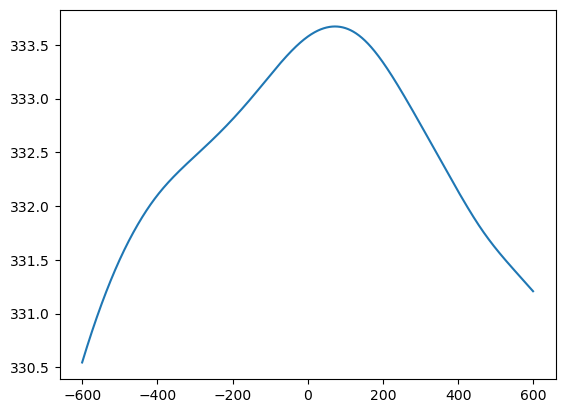

In [47]:
plt.plot(np.arange(-600,600,1),scores[4])

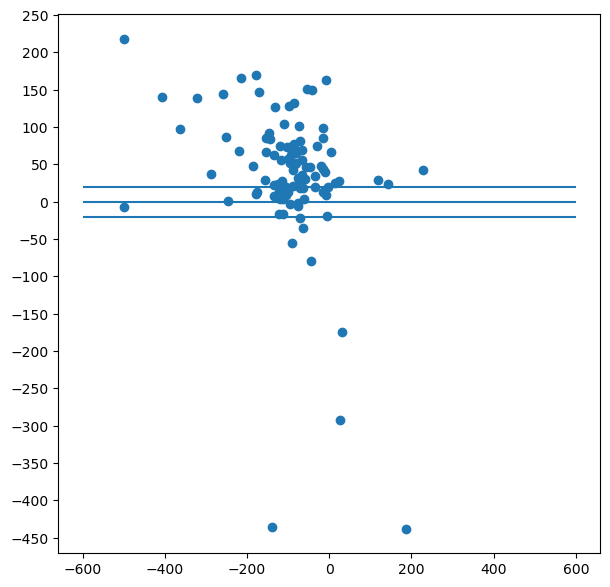

In [49]:
delta_RV =  np.array(predicted_rvs) + np.array(spec_data["barycor"][:100]/1000) - spec_data["RV_1"][:100]
plt.figure(figsize=(7,7))
plt.yticks(np.arange(-650,650,50))
plt.hlines(0,-600,600)
plt.hlines(20,-600,600)
plt.hlines(-20,-600,600)
plt.scatter(spec_data["RV_1"][:100],delta_RV)

In [50]:
np.mean(delta_RV),np.std(delta_RV)

(35.35698758710341, 94.2820734466279)

In [51]:
np.mean(spec_data["RV_1"][:100])

-98.74365258710343

In [52]:
np.mean(predicted_rvs+ np.array(spec_data["barycor"][:100]/1000))

-63.386665

In [28]:
np.where(delta_RV > 30)

(array([ 1,  4,  6,  7,  8,  9, 11, 13, 14, 16, 18, 19, 20, 21, 22, 23, 24,
        25, 26, 27, 28, 30, 31, 33, 34, 35, 39, 45, 46, 48, 49, 50, 51, 52,
        55, 68, 69, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
        88, 89, 90, 91, 92, 93, 94, 96, 98], dtype=int64),)

In [29]:
spec_data["RV_1"]


-135.42979148449058
-287.1731245718199
-99.76800425129987
-120.67985509234
-54.9376255343362
-63.86588195576411
-259.10810642360127
-500.0
-72.0004437756831
5.457385130712512
-139.93927124936704


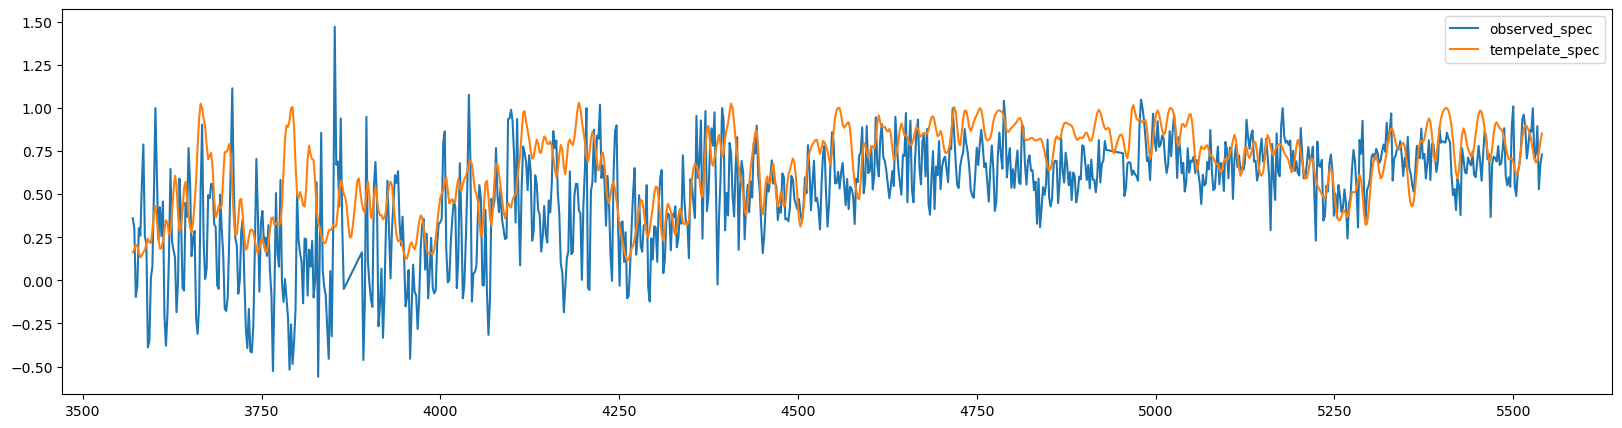

In [31]:
obs_wav = np.linspace(3570,5540,936)
plt.figure(figsize=(20,5))
ex_idx = 4

plt.plot(obs_wav,observed_specs[ex_idx],label="observed_spec")
plt.plot(obs_wav,norm_tmplt_specs[min_score_idx[ex_idx]],label="tempelate_spec")
plt.legend()

In [32]:
delta_RV

21.890191484490572
33.63352457181992
13.228404251299864
-1.8597449076600014
154.5689255343362
-37.502818044235894
143.90660642360126
120.42869999999999
80.42914377568309
66.21621486928748
-247.38712875063294
